In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf

host,=!uname -n
print("Running on " + host)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
print("Tensorflow version is: %s" % tf.__version__)
print("GPU available for TF:  %s" % tf.test.is_gpu_available())

Running on scylla
2 Physical GPUs, 2 Logical GPUs
Tensorflow version is: 2.0.0-beta0
GPU available for TF:  True


In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (8,4)})

---
# Putting the Training Setup to a Test 
Before we engage in a full-blown noisy market model with our setup, we'd better try it at a super-trivial - yet similar - problem. It should be able to solve this. Only after we succeed here it makes sense to conquer the rest of the world. Here's where we can still tell whether it's a bug or just an inappropriate architecture choice, if it doesn't work.

## Trading Sine Waves
The goal of this exercise is to provide a super-simple trading problem that any chartist would outperform the market with. A synthetic equity called 'SINX' exhibits a wave-like structure. The clue is that the local extrema of the resulting chart are easily exploitable: If it looks like a *turnaround signal*, it is a turnaround signal! So a chartist would simply have to observe the last 2 prices at any point in time. If the trend turns, it'll stay in the new direction for long enough to profit from it. To make it slightly less easy we introduce a second equity called 'COSX'. Now the claim is: Every trading algorithm that is supposed to learn patterns MUST be able to exploit this trivial market. Note that we can claim so exactly because this market exhibits *inertia* - continuity in movement.

In [7]:
def SINX(x):
    x1=x+3*np.sin(x/5.5)
    return 10 + np.sin(x1/10) + np.sin(x1/33) + np.sin(x1/100)

def COSX(x):
    x2=0.7*x+2*np.cos(x/5.5)
    return 12 + np.cos(x2/10) - np.cos(x2/23) + np.cos(x2/100)

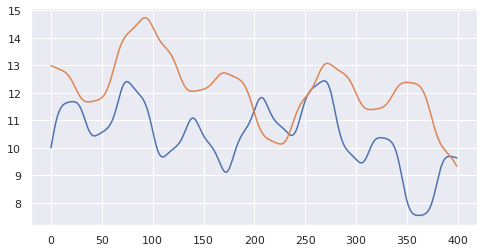

In [8]:
x=np.arange(400)
plt.plot(x,SINX(x))
plt.plot(x,COSX(x))

### Benchmark
Observe how easy it is to extract an actionable signal from the above chart!

In [9]:
# momentum
delta_sin = SINX(x)[1:] - SINX(x)[:-1]
delta_sin[:100]

array([ 0.21578248,  0.2096061 ,  0.19783383,  0.18152987,  0.16207256,
        0.14095171,  0.11957624,  0.09912613,  0.08046718,  0.0641292 ,
        0.05033527,  0.03906275,  0.03011663,  0.023199  ,  0.01796462,
        0.01405775,  0.01113025,  0.00884408,  0.00686338,  0.00484264,
        0.00241767, -0.00079406, -0.00517848, -0.01109199, -0.01881064,
       -0.02846559, -0.03997468, -0.05298449, -0.06684129, -0.08060838,
       -0.09314158, -0.10322221, -0.10973139, -0.11183365, -0.1091297 ,
       -0.10174036, -0.09029881, -0.07585093, -0.05968716, -0.04314527,
       -0.02742693, -0.01346185, -0.00183716,  0.00720872,  0.01374174,
        0.01805789,  0.02059961,  0.02187844,  0.0224137 ,  0.02269067,
        0.02313766,  0.02411862,  0.02593641,  0.02884124,  0.03303882,
        0.03869277,  0.04591686,  0.05475445,  0.06514498,  0.07688132,
        0.08956644,  0.10258162,  0.11508189,  0.1260329 ,  0.13429807,
        0.13877368,  0.13855498,  0.13310261,  0.12237108,  0.10

In [10]:
# timing of momentum changes
chng_sin = .5 * (np.sign(delta_sin[1:]) - np.sign(delta_sin[:-1]))
chng_sin[:100] 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [11]:
buy_sin = x[np.where(chng_sin == 1)]
sell_sin = x[np.where(chng_sin == -1)]

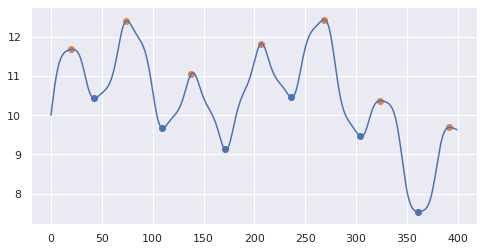

In [12]:
plt.plot(x,SINX(x))
plt.scatter(buy_sin, SINX(buy_sin))
plt.scatter(sell_sin, SINX(sell_sin));

The return per share is obviously the sum of the differences between sell and buy price for each tx pair during the period

In [13]:
np.sum(SINX(sell_sin[1:]) - SINX(buy_sin))

11.0762104995922

That's about 100% annual return. Not bad. But for a human being that was easy. Let's see how the machines are doing on this task...

# Deep Deterministic Policy Gradient (Silver 2016)

In our setup, the state space is given by $\mathbb{S} = \mathbb{R}^{(N_M \cdot N_H+N_P)}$, with $N_M$ being the number of marktet signals to observe - here $N_M=2$, $N_H$ being the length of the history of market signals to take into consideration, here $N_H=3$, and $N_P$ being the size of the portfolio including the cash position, here $N_P=3$. The dimension of the action space $\mathbb{A} = \mathbb{R}^{N_P}$ is determined by the size of the portfolio, obviously. 

In [14]:
N_M = 2
N_H = 7
N_P = 3

DDPG employs two actor-critic network pairs:

- Primary actor - a deterministic policy network with trainable parameters $\theta$: $\mu(s|\theta): \mathbb S \rightarrow \mathbb{A}$
- Primary critic - an action-value function with trainable parameters $\phi$:
$Q(s,a|\phi): \mathbb S \times \mathbb A \rightarrow \mathbb{R}$

- Target actor - a deterministic policy network with trainable parameters $\theta^\prime$: $\mu^\prime(s|\theta^\prime): \mathbb S \rightarrow \mathbb{A}$
- Target critic - an action-value function with trainable parameters $\phi^\prime$:
$Q^\prime(s,a|\phi^\prime): \mathbb S \times \mathbb A \rightarrow \mathbb{R}$

For the networks we choose combinations of LSTMs and feed forward networks.

### DDPG - The Algorithm
---

Using the discount factor $\gamma$ and the target learning rate $\tau$<br/>
Randomly initialize the primary networks</br>
Initialize the target networks $\mu^\prime$ and $Q^\prime$ with the weights of the primary network $\theta^\prime \leftarrow \theta$, $\phi^\prime \leftarrow \phi$</br>
Initialize replay buffer $R$</br>
**for** episode = 1, $N_E$ **do**</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Initialize random process $\mathcal N$ for action exploration</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Receive initial observation state $s_1$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**for** t=1, L (length of each episode), **do**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Select action $a_t = \mu(s_t|\theta) + \mathcal{N}_t$ according to the current policy and exploration noise<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Execute action $a_t$ and observe reward $r_t$ and new state $s_{t+1}$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Store transition $(s_t, a_t, r_t, s_{t+1})$ in $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Sample a random minibatch of $N_B$ transitions $(s_i, a_i, r_i, s_{i+1})$ from $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Calculate the $Q$-targets: $y_i = r_i + \gamma Q^\prime(s_{i+1}, \mu^\prime(s_{i+1}|\theta^\prime)|\phi^\prime)$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the primary critic by minimizing the loss: $L = \frac{1}{N_B}\sum_i(y_i-Q(s_i, a_i|\phi))^2$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the actor policy using the sampled policy gradient:
$$
\nabla_\theta J \approx \frac{1}{N_B}\sum_{i=1}^{N_B}\nabla_a Q(s, a|\phi)|_{s=s_i, a=\mu(s_i)}
\nabla_\theta \mu(s|\theta)|_{s_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the target networks: 
$$
\theta^\prime \leftarrow \tau \theta + (1-\tau) \theta^\prime
$$

$$
\phi^\prime \leftarrow \tau \phi + (1-\tau) \phi^\prime
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**end for**<br/>
**end for**<br/>

---

In [15]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The Networks

## The Primary Actor
$\mu(s|\theta): \mathbb S \rightarrow \mathbb{A}$, &nbsp;&nbsp;&nbsp;&nbsp;
$\mathbb{S} = \mathbb{R}^{(N_M \cdot N_H+N_P)}$, &nbsp;&nbsp;&nbsp;&nbsp;
$\mathbb{A} = \mathbb{R}^{N_P}$

We create an LSTM network with a dense head comprising of $N_P$ output signals
These are then concatenated with the signal from the current portfolio 
the $2 \cdot N_P$ layer is then fed through a feed-forward network with a configurable number of layers and units per layer. We'll use 2 hidden layers with 32 units each for a start

In [16]:
class InvestorActor(tf.keras.Model):
    def __init__(self, n_lstm, n_market, n_hist, n_portfolio, hidden_layout):
        super(InvestorActor, self).__init__()

        self.n_hist = n_hist
        self.n_market = n_market
        self.n_portfolio = n_portfolio
        
        self.lstm = tf.keras.layers.LSTM(
            units = n_lstm, 
            input_shape=[None, n_hist, n_market],
            return_sequences=False)

        # This is the lstm's point of view not yet considering the current portfolio
        self.lstm_out = tf.keras.layers.Dense(n_portfolio, activation = 'softmax')

        self.dense_layers=[]
        for size in hidden_layout:
            self.dense_layers.append(
                tf.keras.layers.Dense(size, activation = 'relu'))

        self.dense_layers.append(
            tf.keras.layers.Dense(n_portfolio, activation = 'softmax'))
        
        
    def call(self, inputs):
        """
        We're using this only for the build step of the model. Not ever during training
        Use portfolio(market, portfolio) instead.
        """
        market = inputs[:, :self.n_hist * self.n_market]
        market = tf.reshape(market, shape = [-1, self.n_hist, self.n_market])
        portfolio = inputs[:, self.n_hist * self.n_market:]
        return self.portfolio(market, portfolio)
        
        
    def portfolio(self, market, portfolio):
        """
        market: batch of market histories. Shape: [N_B, n_hist, n_market]
        portfolio: batch of current portfolios. Shape: [N_B, n_portfolio]
        """
        market = tf.cast(market, dtype=tf.float32)
        portfolio = tf.cast(portfolio, dtype=tf.float32)
        
        # compute the market history's contribution
        out = self.lstm(market)
        out = self.lstm_out(out) # shape = n_portfolio

        # take the current portfolio into considerations
        out = tf.concat([out, portfolio], axis=1)
        
        # compute the final recommendation
        for layer in self.dense_layers:
            out = layer(out)
        return out

In [17]:
N_LSTM_UNITS = 128
DENSE_LAYOUT= [32, 32, N_P]

primary_actor = InvestorActor(
    n_lstm=N_LSTM_UNITS, 
    n_hist=N_H, n_market=N_P-1, 
    n_portfolio = N_P,
    hidden_layout=[32, 32])

In [18]:
primary_actor(np.random.random([1, 7*2+3]))

<tf.Tensor 'investor_actor/dense_3/Softmax:0' shape=(1, 3) dtype=float32>

In [19]:
primary_actor.summary()

Model: "investor_actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  67072     
_________________________________________________________________
dense (Dense)                multiple                  387       
_________________________________________________________________
dense_1 (Dense)              multiple                  224       
_________________________________________________________________
dense_2 (Dense)              multiple                  1056      
_________________________________________________________________
dense_3 (Dense)              multiple                  99        
Total params: 68,838
Trainable params: 68,838
Non-trainable params: 0
_________________________________________________________________


### Sanity-checking shapes with random input

A batch of five market observations with 7 steps back in history of 2 different equities

In [20]:
market = np.random.random([5, 7, 2])
market.shape

(5, 7, 2)

A batch of five different current portfolios including the cash position

In [21]:
portfolio = np.random.random([5, 3])
portfolio.shape

(5, 3)

In [22]:
primary_actor.portfolio(market, portfolio)

<tf.Tensor 'dense_3/Softmax:0' shape=(5, 3) dtype=float32>

Resulting in a batch of 5 different portfolio recommendations, now including the cash position.

## Target Actor
We're initializing the target actor with the weights of the primary actor.

In [23]:
target_actor = InvestorActor(
    n_lstm=N_LSTM_UNITS, 
    n_hist=N_H, n_market=N_P-1, 
    n_portfolio = N_P,
    hidden_layout=[32, 32])
target_actor(np.random.random([1, 7*2+3]));

In [24]:
target_actor.set_weights(primary_actor.get_weights())

Sanity check: It produces the same recommendations as the primary actor.

In [25]:
target_actor.portfolio(market, portfolio)

<tf.Tensor 'dense_7/Softmax:0' shape=(5, 3) dtype=float32>

## Primary Critic
The critic follows the same architecture, with two obvious differences: The output of the critic is a single number, and the additional input that is - just like the portfolio - also concatenated to the LSTM output before all three: LSTM out, portfolio, and actions are fed into the feed forward network.

In [26]:
class InvestorCritic(tf.keras.Model):
    def __init__(self, n_lstm, n_market, n_hist, n_portfolio, hidden_layout):
        super(InvestorCritic, self).__init__()

        self.n_hist = n_hist
        self.n_market = n_market
        self.n_portfolio = n_portfolio
        self.n_actions = n_portfolio
        
        self.lstm = tf.keras.layers.LSTM(
            units = n_lstm, 
            input_shape=[None, n_hist, n_market],
            return_sequences=False)

        # This is the lstm's point of view not yet considering the current portfolio
        self.lstm_out = tf.keras.layers.Dense(n_portfolio, activation = 'softmax')

        self.dense_layers=[]
        for size in hidden_layout:
            self.dense_layers.append(
                tf.keras.layers.Dense(size, activation = 'relu'))

        self.dense_layers.append(
            tf.keras.layers.Dense(1, activation = None))
        
        
    def call(self, inputs):
        """
        We're using this only for the build step of the model. Not ever during training
        Use portfolio(market, portfolio) instead.
        """
        market = inputs[:, :self.n_hist * self.n_market]
        market = tf.reshape(market, shape = [-1, self.n_hist, self.n_market])
        portfolio = inputs[:, self.n_hist * self.n_market:
                           self.n_hist * self.n_market + self.n_actions]
        actions = inputs[:, self.n_hist * self.n_market + self.n_actions:]
        return self.qvalue(market, portfolio, actions)
        
        
    def qvalue(self, market, portfolio, actions):
        """
        market: batch of market histories. Shape: [N_B, n_hist, n_market]
        portfolio: batch of current portfolios. Shape: [N_B, n_portfolio]
        """
        market = tf.cast(market, dtype=tf.float32)
        portfolio = tf.cast(portfolio, dtype=tf.float32)
        actions = tf.cast(actions, dtype=tf.float32)
        
        # compute the market history's contribution
        out = self.lstm(market)
        out = self.lstm_out(out) # shape = n_portfolio

        # take the current portfolio into considerations
        out = tf.concat([out, portfolio, actions], axis=1)
        
        # compute the final recommendation
        for layer in self.dense_layers:
            out = layer(out)
        return out

In [27]:
primary_critic = InvestorCritic(
    n_lstm=N_LSTM_UNITS, 
    n_hist=N_H, n_market=N_P-1, 
    n_portfolio = N_P,
    hidden_layout=[32, 32])
primary_critic(np.random.random([1, 7*2+3+3]));

In [28]:
primary_critic.summary()

Model: "investor_critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                multiple                  67072     
_________________________________________________________________
dense_8 (Dense)              multiple                  387       
_________________________________________________________________
dense_9 (Dense)              multiple                  320       
_________________________________________________________________
dense_10 (Dense)             multiple                  1056      
_________________________________________________________________
dense_11 (Dense)             multiple                  33        
Total params: 68,868
Trainable params: 68,868
Non-trainable params: 0
_________________________________________________________________


In [29]:
primary_critic.qvalue(market, portfolio, actions=portfolio)

<tf.Tensor 'dense_11/BiasAdd:0' shape=(5, 1) dtype=float32>

## Target Critic
We're initializing the target actor with the weights of the primary actor.

In [30]:
target_critic = InvestorCritic(
    n_lstm=N_LSTM_UNITS, 
    n_hist=N_H, n_market=N_P-1, 
    n_portfolio = N_P,
    hidden_layout=[32, 32])
target_critic(np.random.random([1, 7*2+3+3]));

In [31]:
target_critic.set_weights(primary_critic.get_weights())

Sanity check: It produces the same recommendations as the primary critic.

In [32]:
target_critic.qvalue(market, portfolio, actions=portfolio)

<tf.Tensor 'dense_15/BiasAdd:0' shape=(5, 1) dtype=float32>

---